In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.2 MB/s eta 0:00:00


In [2]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [3]:
# 2. Đọc file dữ liệu chứng khoán
df = pd.read_csv('AAPL.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index(['Date'])
df = df[['Close']]
df = df.dropna() # Drop missing values
#df = df.reset_index(drop=True) # Reset the index

In [4]:
df

,Close
Date,
2017-01-03,29.037500
2017-01-04,29.004999
2017-01-05,29.152500
2017-01-06,29.477501
2017-01-09,29.747499
...,...
2023-05-26,175.429993
2023-05-30,177.300003
2023-05-31,177.250000


In [5]:
# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

<Axes: xlabel='Date'>

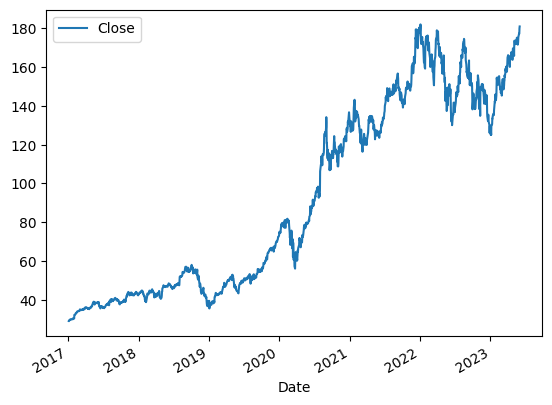

In [6]:
df.plot()

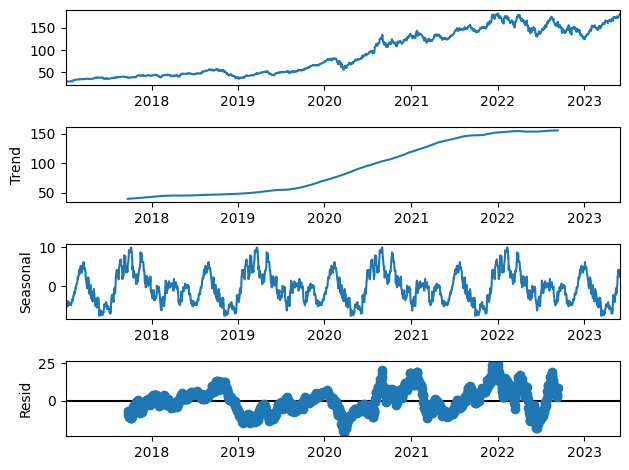

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data = seasonal_decompose(df, model="additive", period = 365)
decompose_data.plot();

In [8]:
from pmdarima.arima.utils import ndiffs
ndiffs(df.Close.dropna(), test="adf")

1

In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
res = adfuller(df['Close'].dropna())
print(f"p-value: {res[1]}")

p-value: 0.9203515059234455


In [11]:
res = adfuller(df['Close'].diff().dropna())
print(f"p-value: {res[1]}")

p-value: 1.964588983544216e-14


In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [13]:
diff = df[['Close']].copy(deep=True)
diff['firstDiff'] = df['Close'].diff()
diff

,Close,firstDiff
Date,,
2017-01-03,29.037500,NaN
2017-01-04,29.004999,-0.032501
2017-01-05,29.152500,0.147501
2017-01-06,29.477501,0.325001
2017-01-09,29.747499,0.269998
...,...,...
2023-05-26,175.429993,2.439988
2023-05-30,177.300003,1.870010
2023-05-31,177.250000,-0.050003


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


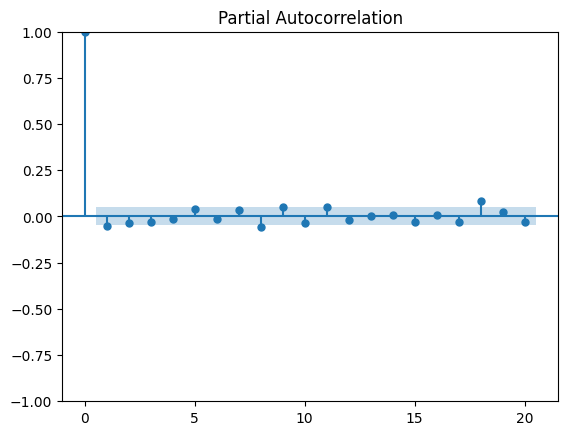

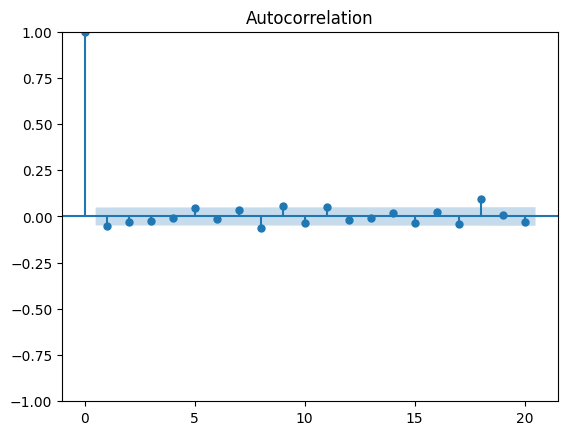

In [14]:
plot_pacf(diff['firstDiff'].dropna(), lags=20);
plot_acf(diff['firstDiff'].dropna(), lags=20);

SARIMAX
---------------------------------------

In [15]:
sarimax = sm.tsa.statespace.SARIMAX(train_data,order=(1,1,1),seasonal_order=(1,1,1,12)).fit()
sarimax.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                  969
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1702.295
Date:                            Tue, 20 Jun 2023   AIC                           3414.590
Time:                                    16:00:11   BIC                           3438.904
Sample:                                         0   HQIC                          3423.851
                                            - 969                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4312      0.089     -4.840      0.000      -0.606      -0.257
ma.L1          0.2869      0.095      3.015      0.003       0.100       0.473
ar.S.L12       0.0055      0.022      0.248      0.804      -0.038       0.049
ma.S.L12      -0.9787      0.012    -82.614      0.000      -1.002      -0.955
sigma2         1.9821      0.038     52.008      0.000       1.907       2.057
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              6969.77
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):              18.21   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
from sklearn.metrics import mean_squared_error
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])

start=len(train_data)
end=len(train_data)+len(test_data)
pred_test = sarimax.predict(start, end)[1:]

pred_val = sarimax.predict(len(train_data)+len(test_data), len(train_data)+len(test_data)+len(val_data)-1)
print('SARIMAX model MSE:{}'.format(mean_squared_error(y_test,pred_test)))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


SARIMAX model MSE:95.65496955955291


In [17]:
# last_index =  df.index[-1]
# last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

start=len(train_data)+len(test_data)+len(val_data)
end=len(train_data)+len(test_data)+len(val_data)+30
pred_30 = sarimax.predict(start, end)[1:]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [18]:
# 8. Tính RMSE
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
import math
from math import sqrt

MAPE = mean_absolute_percentage_error(test_data, pred_test)
RMSE = sqrt(mean_squared_error(test_data, pred_test))
MAE = mean_absolute_error(test_data, pred_test)

Accuracy = 1 - MAPE

In [19]:
print('---------------------')
print("Test RMSE:", RMSE)
print("Test MAPE:", MAPE)
print("Test MAE:", MAE)
print('---------------------')
print("Test Accuracy:", Accuracy)

---------------------
Test RMSE: 9.780335861285792
Test MAPE: 0.05122308522106971
Test MAE: 7.5801068462553385
---------------------
Test Accuracy: 0.9487769147789303


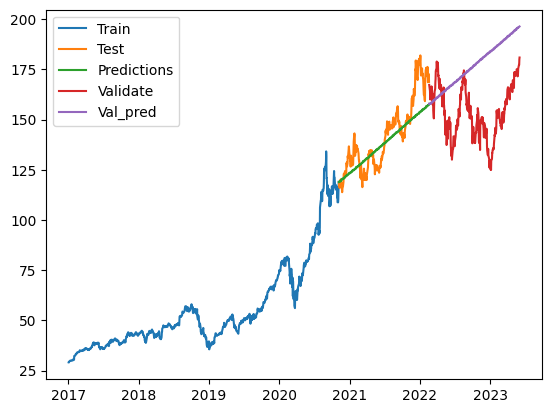

In [20]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, pred_test)
plt.plot(val_data.index, val_data['Close'])
plt.plot(val_data.index, pred_val)
plt.legend(['Train', 'Test', 'Predictions', 'Validate', 'Val_pred'])
plt.show()